In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np 
import os
import pandas as pd 
import PIL
import tensorflow as tf
import time
import zipfile

from PIL import Image
from tensorflow import data, io
from tensorflow.keras import layers


2025-07-02 01:46:41.730992: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751420801.754377    1682 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751420801.761394    1682 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Step 1: Problem Description
This Kaggle competition aims to use a Generative Adversarial Network (GAN) to generate 7,000 to 10,000 images in the style of Monet. The submission will leverage a zip file of generated jpeg images. 

The GAN will use provided images of Monet paintings to train the model and provided images of photos to generate new Monet-style images.  The generated images will be evaluated using the MiFID (Memorization-informed Fréchet Inception Distance), in which a smaller number indicates a better performing model.

In [2]:
DATA_PATH = '/kaggle/input/gan-getting-started'
OUTPUT_PATH = "/kaggle/working/images/"

monet_path = os.path.join(DATA_PATH, 'monet_tfrec')
photo_path = os.path.join(DATA_PATH, 'photo_tfrec')

## Data Description
I created a list of the Monet TFRecord and photo TFRecord files.  Each file contains a collection of images.  There are 5 Monet TFRecord and 20 photo TFRecord files.  The Kaggle competition indicates the training dataset contains 300 Monet paintings and 7028 photos and all images are 256x256 pixels.

In [3]:
monet_file_list = io.gfile.glob(os.path.join(monet_path, '*.tfrec'))
photo_file_list = io.gfile.glob(os.path.join(photo_path, '*.tfrec'))
print(f'Monet files: {len(monet_file_list)}')
print(f'Photos files: {len(photo_file_list)}')

Monet files: 5
Photos files: 20


# Step 2: Exploratory Data Analysis (EDA)

## Confirm image size
As expected, both the Monet and photo images are 256x256 pixels with RGB color channels.

In [4]:
def parse_item(item):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string)
    }
    return io.parse_single_example(item, feature_description)

In [5]:
sample_image = next(iter(data.TFRecordDataset(monet_file_list[0])))
parsed_record = parse_item(sample_image)
image = io.decode_image(parsed_record['image']).numpy()
print(f'Monet of size {image.shape}')

sample_image = next(iter(data.TFRecordDataset(photo_file_list[0])))
parsed_record = parse_item(sample_image)
image = io.decode_image(parsed_record['image']).numpy()
print(f'Photo of size {image.shape}')

Monet of size (256, 256, 3)
Photo of size (256, 256, 3)


I0000 00:00:1751420833.805025    1682 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751420833.805804    1682 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## View Samples
I displayed a couple Monet and photo images to get an idea of what the data looks like.

In [6]:
IMAGE_SHAPE = image.shape
IMAGE_SIZE = IMAGE_SHAPE[0:2]
IMAGE_CHANNELS = IMAGE_SHAPE[2]

def display_images(dataset, num_images):
    f, axes = plt.subplots(1, num_images, figsize=(6,6))
    for i, record in enumerate(dataset.take(num_images)):
        parsed_record = parse_item(record)
        image = tf.image.decode_jpeg(parsed_record['image'], channels=3)
        axes[i].imshow(image)
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

### Sample Monets

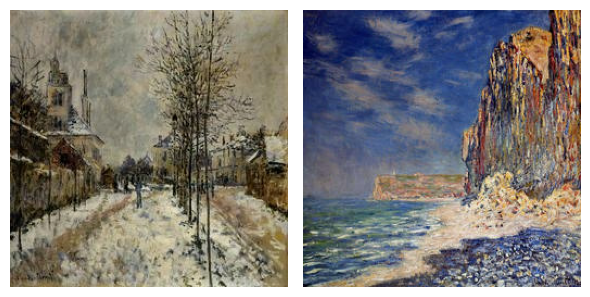

In [7]:
display_images(data.TFRecordDataset(monet_file_list[0]), 2)    

### Sample Photos

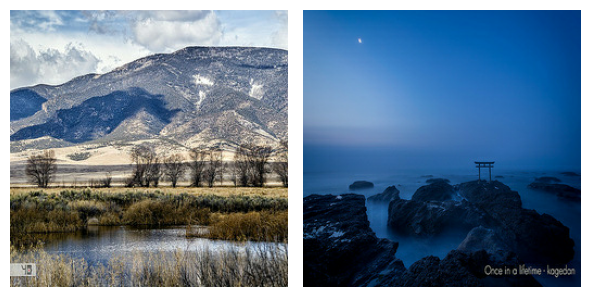

In [8]:
display_images(data.TFRecordDataset(photo_file_list[0]), 2)  

## Image count
I confirmed there are 300 Monet paintings and a little over 7,000 photos.

In [9]:
def count_items(filenames):
    n = [int(data.TFRecordDataset(f).reduce(np.int64(0), lambda x, _: x + 1)) for f in filenames]
    return np.sum(n)

print(f'Monet images: {count_items(monet_file_list)}')
print(f'Photos: {count_items(photo_file_list)}')

Monet images: 300
Photos: 7038


## Pixel intensity
Visualizing a Monet and photo using RGB pixel intensity helps to explain how the image transformation works.  In essence, an image is a matrix of numbers to represent the color in each pixel.  Changing those numbers changes the color of a pixel, and thereby creates a new image.

As shown below, the Monet and the photo are different images and, thus, have different pixel intensities.  

In [10]:
def plot_RGB(img_path):
    img = Image.open(img_path)
    r_channel, g_channel, b_channel = img.split()
    
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.hist(np.array(r_channel).flatten(), bins=256, range=(0, 256), color='red', alpha=0.7)
    plt.title('Red Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 4, 3)
    plt.hist(np.array(g_channel).flatten(), bins=256, range=(0, 256), color='green', alpha=0.7)
    plt.title('Green Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 4, 4)
    plt.hist(np.array(b_channel).flatten(), bins=256, range=(0, 256), color='blue', alpha=0.7)
    plt.title('Blue Channel Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

### Monet

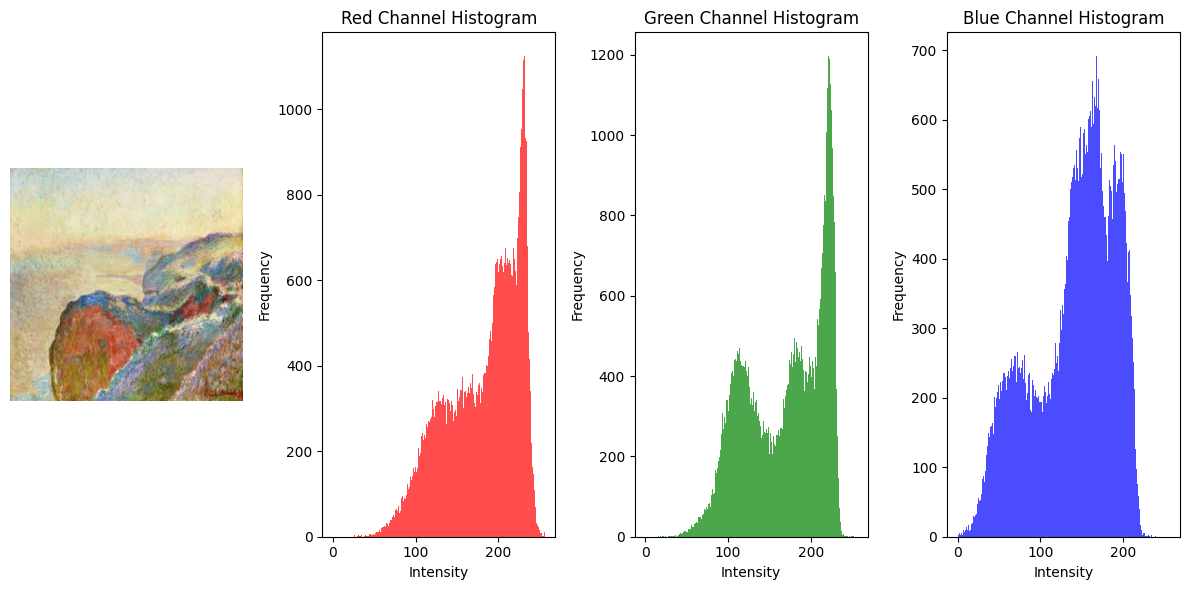

In [11]:
plot_RGB('/kaggle/input/gan-getting-started/monet_jpg/000c1e3bff.jpg')

### Photo

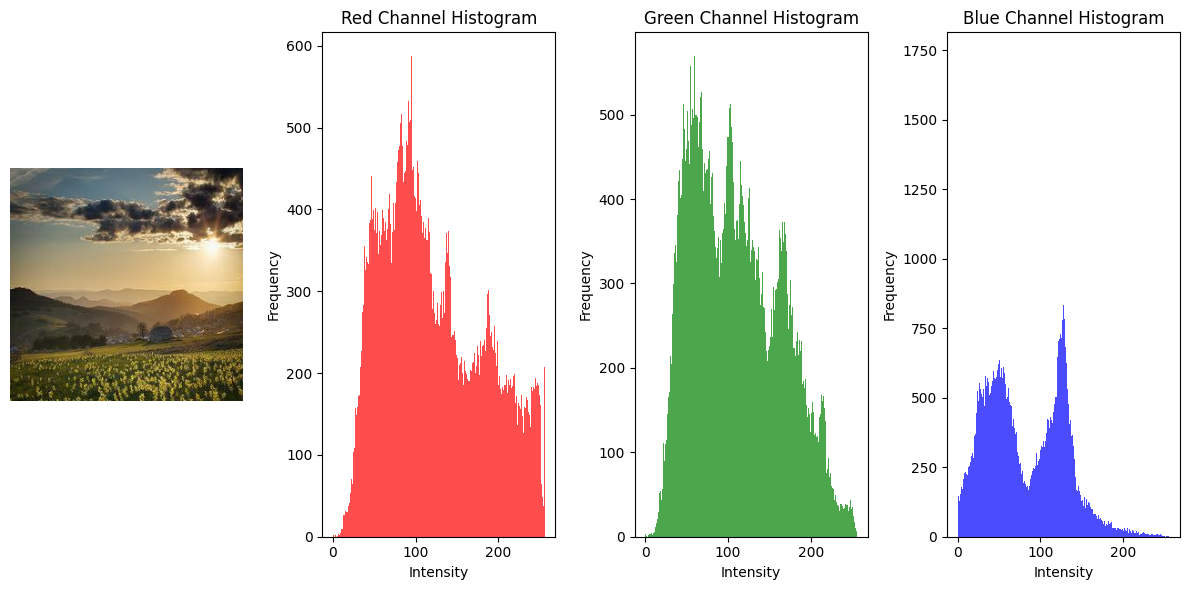

In [12]:
plot_RGB('/kaggle/input/gan-getting-started/photo_jpg/00068bc07f.jpg')

## Data Cleaning
Before creating the model, I need to preprocess the data using the following steps:
* Parse the TFRecord files and decode the image data
* Scale the pixel values from [0, 255] to [-1, 1] - this enables more efficient and stable training by keeping the gradients within a smaller range

In [13]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=IMAGE_CHANNELS)
    image = (tf.cast(image, tf.float32) / 127.5) - 1 #scale to [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def parse_record(record):
    parsed_record = parse_item(record)
    image = decode_image(parsed_record['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_record, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

In [14]:
monet_ds = load_dataset(monet_file_list).batch(1)
photo_ds = load_dataset(photo_file_list).batch(1)

### Data Check 
Now that I've loaded the data into datasets, I want to do a quick check to make sure the images are loaded into the dataset correctly.  Note that I need to rescale the images before displaying because I scaled the images to [-1, 1] in the ```decode_image``` function above.

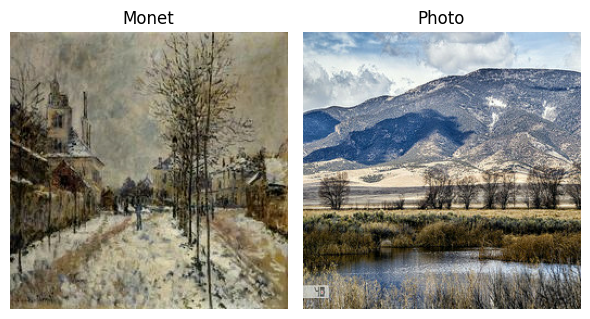

In [15]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

f, axes = plt.subplots(1, 2, figsize=(6,6))
axes[0].set_title('Monet')
axes[0].imshow(example_monet[0] * 0.5 + 0.5)
axes[0].axis('off')

axes[1].set_title('Photo')
axes[1].imshow(example_photo[0] * 0.5 + 0.5)
axes[1].axis('off')
    
plt.tight_layout()
plt.show()

# Step 3:  Model Architecture
A Generative Adversarial Network (GAN) consists of two models, a generator and a discriminator, that work against each other.  The generator creates the images, while the discriminator tries to distinguish real from generated images.  

## Architectural Options
There many GAN architectures available, but I will discuss a few main GAN architectures.

* **DCGAN** A Deep Convolutional GAN (DCGAN) starts with a random vector of noise to create new images "from scratch."  It then uses transposed convolution layers to upsample/decode the noise vector until reaching a desired output size.  The discriminator accepts an image and outputs a probability of that image being real (1) or generated (0).  DCGAN could fit in this use case if we wanted to create Monet-style images from scratch rather than transforming existing images.

* **pix2pix** A pix2pix model learns the mapping between an input image and its corresponding output image.  This approach would not apply in this case because we do not have paired data (i.e,. a single image presented in both photo and Monet-style).

* **CycleGAN** A Cycle-Consistent GAN (CycleGAN) takes the concept of "cycling" an image (i.e., taking an input image, transforming it to a different state, and then transforming it back to the original state) to compare how close the original image is to the cycled image.  A CycleGAN is appropriate when the use case requires transforming an existing image (i.e., photo to Monet-style in this case).  CycleGANs are also appropriate in the absense of paired data.  In contrast to pix2pix, pix2pix learns the mapping between two images, whereas CycleGAN learns the mapping between two domains (i.e., photo and Monet-style).  In contrast to DCGAN, CycleGAN requires two generators (i.e., photo -> Monet and Monet -> photo), which adds a little extra work when defining the model.

I will use a CycleGAN architecture because it is appropriate for unpaired images and is well-suited for image transformation use cases.

## CycleGAN
The basic idea of a CycleGAN is to take an image, convert it to something else, and then convert it back its original form to ensure that it is similar to the original image.  In this case, we want to take a photo, convert it to Monet-style, and then convert it back to a photo.  This "cycle" allows the model to learn characteristics between the original form and the converted form of the image.  A CycleGAN is appropriate for this use case because we do not have "paired" data for the model (i.e., we do not have the same image presented both in photo and Monet-style forms).  I referenced several CycleGAN tutorials, as listed in the references section, when creating this model.

### Encoder/Decoder
We will use a U-Net architecture for the CycleGAN model, which has a few key components:
* **Encoder**:  Encoding the input pulls features out of the input by "downsampling" the input to reduce dimensionality and increase filters

* **Decoder**:  Decoding the input "upsamples" the input to increase dimensionality and generate the new image

* **Skip Connections**:  Skip connections allow the model to send details from a layer in the encoder to the corresponding layer in the decoder

The encoder uses a convolution layer, whereas the decoder uses a transposed convolution layer.  These layers will be used to construct the model later in this notebook.

In [16]:
def encode(filters, kernel_size=4, normalize=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if normalize:
        result.add(layers.Normalization())

    result.add(layers.LeakyReLU())

    return result

In [17]:
def decode(filters, kernel_size=4, dropout=False):
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, 
                                      kernel_size, 
                                      strides=2,
                                      padding='same',
                                      kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                      use_bias=False))

    result.add(layers.Normalization())

    if dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Generator
I construct the generator, which includes the encoding, decoding, and skip connections of the U-Net architecture described above.  Using a stride size of 2 will decrease the image size by a factor of 2 for each encoder level and increase the image size by a factor of 2 for each decoder level.  The output of each layer is fed into the subsequent layer.  Note that the last layer uses a tanh activation function to output values between [-1, 1].

In [18]:
def Generator():
    inputs = layers.Input(shape=IMAGE_SHAPE) #256x256

    # We have a stride of 2, which decreases the image size by a factor of 2 each pass 
    down_stack = [
        encode(64, normalize=False), # 128x128
        encode(128), # 64x64
        encode(256), # 32x32
        encode(512), # 16x16
        encode(512), # 8x8
        encode(512), # 4x4
        encode(512), # 2x2
        encode(512), # 1x1
    ]

    # The stride of 2 increases the image size by a factor of 2 each pass
    up_stack = [
        decode(512, dropout=True), # 2x2
        decode(512, dropout=True), # 4x4
        decode(512, dropout=True), # 8x8
        decode(512), # 16x16
        decode(256), # 32x32
        decode(128), # 64x64
        decode(64), # 128x128
    ]

    last_layer = layers.Conv2DTranspose(IMAGE_CHANNELS, 
                                  4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                  activation='tanh') #256x256

    data = inputs

    # Encode/Downsample through the model
    skips = []
    for down in down_stack:
        data = down(data)
        skips.append(data)

    skips = reversed(skips[:-1])

    # Decode/Upsample and link the corresponding layers
    for up, skip in zip(up_stack, skips):
        data = up(data)
        data = layers.Concatenate()([data, skip])

    data = last_layer(data)

    return keras.Model(inputs=inputs, outputs=data)

### Discriminator
Now I construct the discriminator, which applies each layer to the output of the preceding layer.  For example, the normalization layer is applied to the output of the convolution layer.

In [19]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = layers.Input(shape=IMAGE_SHAPE, name='input_image')
    data = inputs

    e1 = encode(64, 4, False)(data) 
    e2 = encode(128, 4)(e1) 
    e3 = encode(256, 4)(e2) 
    conv = layers.Conv2D(512, 4, strides=1, padding='same',
                         kernel_initializer=initializer,
                         use_bias=False)(e3) 
    norm = layers.Normalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm)
    outputs = layers.Conv2D(1, 4, strides=1, padding='same',
                         kernel_initializer=initializer)(leaky_relu) 
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

### Instantiate
As mentioned above, I need to create two generators (i.e., photo -> Monet and Monet -> photo).  The following code instantiates the generator and discriminator for both the photo-to-Monet direction and the reversed, Monet-to-photo direction.

In [20]:
photo_to_monet_gen = Generator() # transforms photos to Monet-style
monet_to_photo_gen = Generator() # transforms Monet-style to photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

### Loss Functions
* **Generator**: A discriminator will output a matrix of ones for a real image and zeroes for a generated image.  The generator loss will be determined by how different the result is from a matrix of all ones (i.e., when the discriminator indicates a real image).
  
* **Discriminator**: As mentioned above, the discriminator will output ones for a real image and zeroes for a generated image.  The loss of a discriminator will therefore be the average of (1) the loss of a real image compared to a matrix of all ones and (2) the loss of a generated image compared to a matrix of all zeroes.

* **Cycle**:  The loss for a cycle will be how much a cycled image deviates from the original image.

* **Identity**:  The model's identity loss is calculated by how much an original image differs from a image using its own generator (e.g., compare an original photo with the output of that photo passed through a photo generator).

Note that the ```LAMBDA``` parameter can be used to adjust the impact of the cycle and identity loss values on the overall generator loss.  I will investigate the effect of different lambda values in the hyperparameter tuning section.

In [21]:
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, 
        reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss / 2

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * cycle_loss

def identity_loss(real_image, same_image, LAMBDA):
    id_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * id_loss

### Optimizers
Adam optimizers are appropriate for GAN models because they handle noisy data well, are computationally efficient, and can lead to faster convergence.

In [23]:
photo_to_monet_gen_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
monet_to_photo_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.5)

### Putting it All Together
The init and compile functions are wiring the previously defined components together.  The exciting part of this class is the ```train_step```.  This CycleGAN class is built on top of the Keras Model base class, so the ```train_step``` overrides the functionality in the base class.  The ```train_step```:
* generates images in each direction (photo -> Monet and Monet -> photo), cycled images (e.g., photo -> Monet -> photo), and identity images (e.g., Monet -> Monet)
  
* feeds the generated images into the discriminators

* calculates the loss for the generators and discriminators

* calculates the gradients using the calculated loss values

* applies the gradients to the optimizer

The ```training=True``` argument gets passed through the base class's ```call()``` function and enables specific layers, such as the DropOut layer, to act differently for training versus inference executions.

In [24]:
class CycleGan(keras.Model):
    def __init__(
        self,
        photo_to_monet_gen,
        monet_to_photo_gen,
        monet_discriminator,
        photo_discriminator,
        lambda_weight=10,
    ):
        super(CycleGan, self).__init__()
        self.p_to_m_gen = photo_to_monet_gen
        self.m_to_p_gen = monet_to_photo_gen
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_weight = lambda_weight
        
    def compile(
        self,
        p_to_m_gen_optimizer,
        m_to_p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.p_to_m_gen_optimizer = p_to_m_gen_optimizer
        self.m_to_p_gen_optimizer = m_to_p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo -> monet -> photo
            genned_monet = self.p_to_m_gen(real_photo, training=True)
            cycled_photo = self.m_to_p_gen(genned_monet, training=True)

            # monet -> photo -> monet
            genned_photo = self.m_to_p_gen(real_monet, training=True)
            cycled_monet = self.p_to_m_gen(genned_photo, training=True)

            # generating itself
            same_monet = self.p_to_m_gen(real_monet, training=True)
            same_photo = self.m_to_p_gen(real_photo, training=True)

            # discriminator checking real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator checking genned images
            disc_genned_monet = self.m_disc(genned_monet, training=True)
            disc_genned_photo = self.p_disc(genned_photo, training=True)

            # calculate generator loss - did the generator "fool" the discriminator with a generated image?
            monet_gen_loss = self.gen_loss_fn(disc_genned_monet)
            photo_gen_loss = self.gen_loss_fn(disc_genned_photo)

            # calculate total cycle consistency loss - does the cycled version match the original?
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_weight) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_weight)

            # calculate total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_weight)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_weight)

            # calculate discriminator loss - can the discriminator tell a real from a generated image?
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_genned_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_genned_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.p_to_m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.m_to_p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.p_to_m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.p_to_m_gen.trainable_variables))

        self.m_to_p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.m_to_p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "photo_to_monet_gen_loss": total_monet_gen_loss,
            "monet_to_photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Create and Compile
I create and compile an instance of the CycleGan class and pass in the generators, discriminators, optimizers, and loss functions.

In [25]:
cycle_gan_model = CycleGan(
    photo_to_monet_gen, 
    monet_to_photo_gen, 
    monet_discriminator, 
    photo_discriminator
)

cycle_gan_model.compile(
    p_to_m_gen_optimizer = photo_to_monet_gen_optimizer,
    m_to_p_gen_optimizer = monet_to_photo_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

### Train
Calling the fit function will use the overridden implementation of ```train_step``` described above.

In [26]:
model_results = {}

start_time = time.time()

cycle_history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'CycleGAN - Lambda 10', 
    elapsed_time,
    len(cycle_history.epoch),
    np.min(cycle_history.history['monet_disc_loss']),
    np.min(cycle_history.history['photo_to_monet_gen_loss'])
)

Epoch 1/5


I0000 00:00:1751421810.089584    1745 service.cc:148] XLA service 0x7cba28002d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751421810.089685    1745 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751421810.089694    1745 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751421813.010085    1745 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751421819.970711    1745 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751421820.237938    1745 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751421822.604755    1745 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

300/300 ━━━━━━━━━━━━━━━━━━━━ 113s 216ms/step - monet_disc_loss: 0.5632 - monet_to_photo_gen_loss: 6.3124 - photo_disc_loss: 0.6288 - photo_to_monet_gen_loss: 6.4686
Epoch 2/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 213ms/step - monet_disc_loss: 0.6529 - monet_to_photo_gen_loss: 3.9449 - photo_disc_loss: 0.6551 - photo_to_monet_gen_loss: 4.0987
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - monet_disc_loss: 0.6025 - monet_to_photo_gen_loss: 3.7926 - photo_disc_loss: 0.6389 - photo_to_monet_gen_loss: 3.9827
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - monet_disc_loss: 0.6372 - monet_to_photo_gen_loss: 3.7206 - photo_disc_loss: 0.6117 - photo_to_monet_gen_loss: 3.8958
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - monet_disc_loss: 0.5782 - monet_to_photo_gen_loss: 3.6309 - photo_disc_loss: 0.6033 - photo_to_monet_gen_loss: 3.8117


### Display Generated Image
I generated a couple photos and their transformed versions to see a few generated Monet images.

In [27]:
def display_generated_images(dataset, num_images):
    f, axes = plt.subplots(num_images, 2, figsize=(6,6))
    for i, record in enumerate(dataset.take(num_images)):
        image = photo_to_monet_gen(record)[0].numpy()
        image = (image * 127.5 + 127.5).astype(np.uint8)
        record = (record[0] * 127.5 + 127.5).numpy().astype(np.uint8)

        axes[i, 0].imshow(record)
        axes[i, 1].imshow(image)
        axes[i, 0].set_title("Original Photo")
        axes[i, 1].set_title("Generated Monet")
        axes[i, 0].axis("off")
        axes[i, 1].axis("off")
       
    plt.tight_layout()
    plt.show()

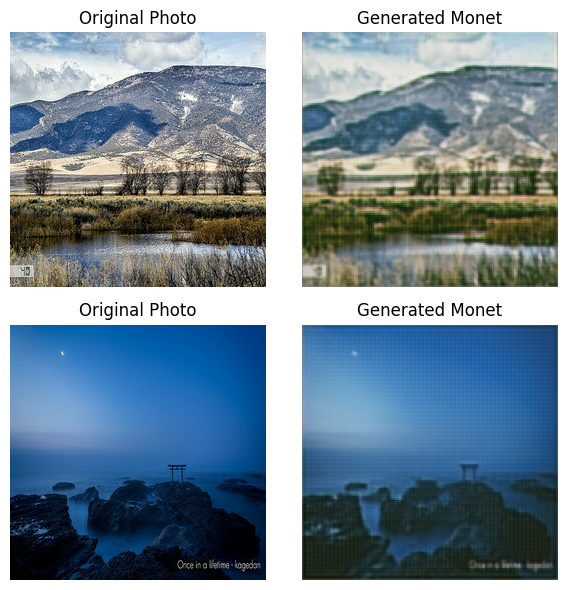

In [28]:
display_generated_images(photo_ds, 2)

## Hyperparameter Tuning
As mentioned above, the lambda hyperparameter determines the impact of the cycle and identity loss values on the overall generator loss.  Common values for a GAN range from 10 to 100, so I tested values of 50 and 100 below.  The model above uses a lambda value of 10.

In [29]:
cycle_gan_model_100 = CycleGan(
    photo_to_monet_gen, 
    monet_to_photo_gen, 
    monet_discriminator, 
    photo_discriminator, 
    lambda_weight=100
)

cycle_gan_model_100.compile(
    p_to_m_gen_optimizer = photo_to_monet_gen_optimizer,
    m_to_p_gen_optimizer = monet_to_photo_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

start_time = time.time()

cycle_history_100 = cycle_gan_model_100.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'CycleGAN - Lambda 100', 
    elapsed_time,
    len(cycle_history_100.epoch),
    np.min(cycle_history_100.history['monet_disc_loss']),
    np.min(cycle_history_100.history['photo_to_monet_gen_loss'])
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 215ms/step - monet_disc_loss: 0.5421 - monet_to_photo_gen_loss: 26.8166 - photo_disc_loss: 0.5785 - photo_to_monet_gen_loss: 26.6169
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - monet_disc_loss: 0.5305 - monet_to_photo_gen_loss: 23.6252 - photo_disc_loss: 0.5622 - photo_to_monet_gen_loss: 23.5414
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - monet_disc_loss: 0.5207 - monet_to_photo_gen_loss: 22.3022 - photo_disc_loss: 0.5396 - photo_to_monet_gen_loss: 22.1467
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - monet_disc_loss: 0.5088 - monet_to_photo_gen_loss: 21.4215 - photo_disc_loss: 0.4881 - photo_to_monet_gen_loss: 21.1635
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - monet_disc_loss: 0.5220 - monet_to_photo_gen_loss: 20.7320 - photo_disc_loss: 0.4198 - photo_to_monet_gen_loss: 20.1904


In [30]:
cycle_gan_model_50 = CycleGan(
    photo_to_monet_gen, 
    monet_to_photo_gen, 
    monet_discriminator, 
    photo_discriminator, 
    lambda_weight=50
)

cycle_gan_model_50.compile(
    p_to_m_gen_optimizer = photo_to_monet_gen_optimizer,
    m_to_p_gen_optimizer = monet_to_photo_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

start_time = time.time()

cycle_history_50 = cycle_gan_model_50.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=5
)

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'CycleGAN - Lambda 50', 
    elapsed_time,
    len(cycle_history_50.epoch),
    np.min(cycle_history_50.history['monet_disc_loss']),
    np.min(cycle_history_50.history['photo_to_monet_gen_loss'])
)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 213ms/step - monet_disc_loss: 0.5352 - monet_to_photo_gen_loss: 10.6237 - photo_disc_loss: 0.4582 - photo_to_monet_gen_loss: 10.2636
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - monet_disc_loss: 0.5325 - monet_to_photo_gen_loss: 10.2286 - photo_disc_loss: 0.4977 - photo_to_monet_gen_loss: 10.0691
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - monet_disc_loss: 0.5111 - monet_to_photo_gen_loss: 10.1505 - photo_disc_loss: 0.4885 - photo_to_monet_gen_loss: 10.0072
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 210ms/step - monet_disc_loss: 0.5226 - monet_to_photo_gen_loss: 10.0411 - photo_disc_loss: 0.5303 - photo_to_monet_gen_loss: 9.9880
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 63s 211ms/step - monet_disc_loss: 0.5291 - monet_to_photo_gen_loss: 9.7742 - photo_disc_loss: 0.5385 - photo_to_monet_gen_loss: 9.7324


In [33]:
def show_model_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    disc_loss = []
    gen_loss = []
    for i in range(len(history.epoch)):
        disc_loss.append(np.min(history.history["monet_disc_loss"][i]))
        gen_loss.append(np.min(history.history["photo_to_monet_gen_loss"][i]))
    
    plt.tight_layout()
    ax1.set_title('Monet Disc Loss')
    ax2.set_title('Photo -> Monet Gen Loss')
    ax1.plot(history.epoch, disc_loss)
    ax2.plot(history.epoch, gen_loss)
    plt.show()

# Step 4: Results and Analysis

As the value of lambda increased, the minimum Monet generator loss increased as expected given that lambda determines the impact of the cycle and identity loss values on the overall generator loss.  However, the minimum loss of the discriminator improved when lambda changed from 10 to 50 but degraded when lambda changed to 100.  The model with the lambda value of 50 was my best performing model in terms of discriminator loss.

The training time of my model remained relatively flat across the different lambda values, which I expected given the role of lambda in the determination of generator loss.  Other hyperparameters, such as learning rate, could influence how long it takes for the model to converge leading to different training durations.



### Lambda = 100
The discriminator loss hit its minimum value at 3 epochs and then sharply increased indicating that the training could have ended after 3 epochs.

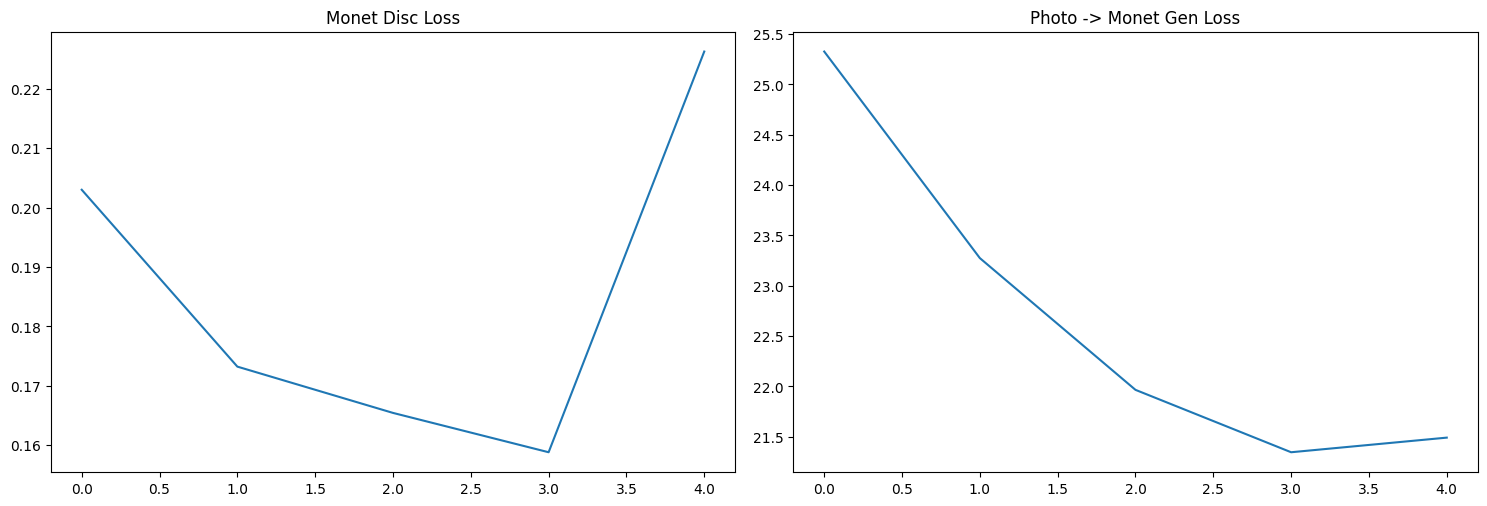

In [34]:
show_model_history(cycle_history_100)

### Lambda = 50
Interestingly, the loss graphs for lambda = 50 seemed more sporadic than lambda = 10.  The minimum discriminator loss was achieved at 2 epochs, indicating a faster convergence than the prior model.

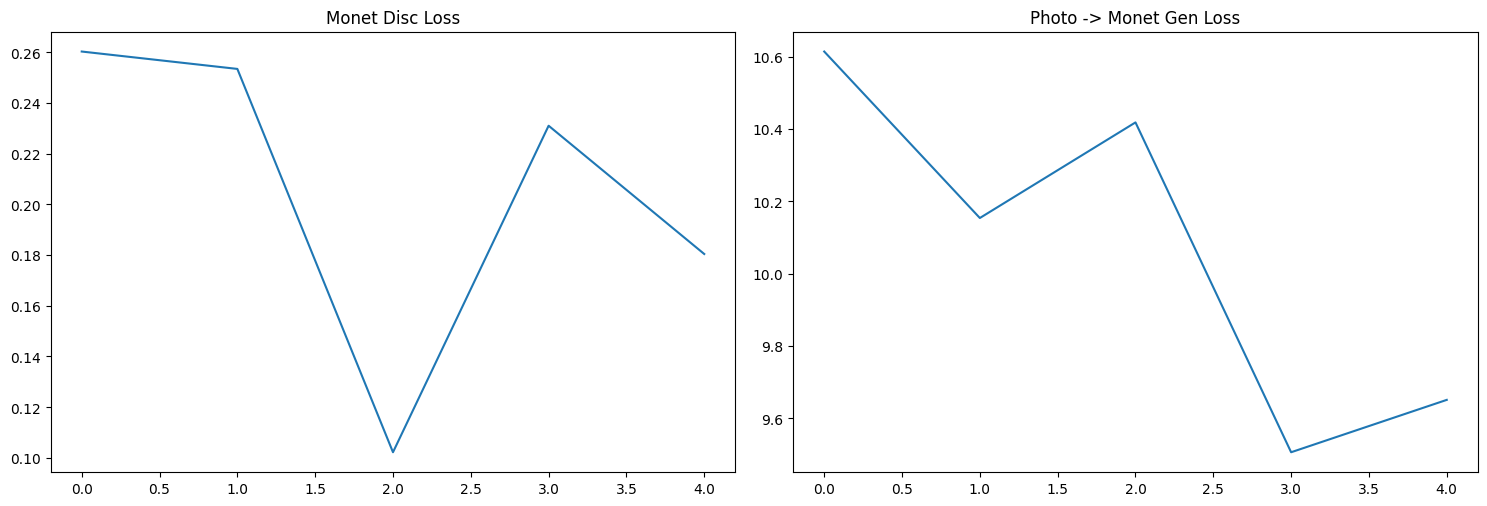

In [35]:
show_model_history(cycle_history_50)

### Lambda = 10
The discriminator loss chart looks similar to that of the lambda = 50 model.  This model also achieved the minimum discriminator loss at 2 epochs.

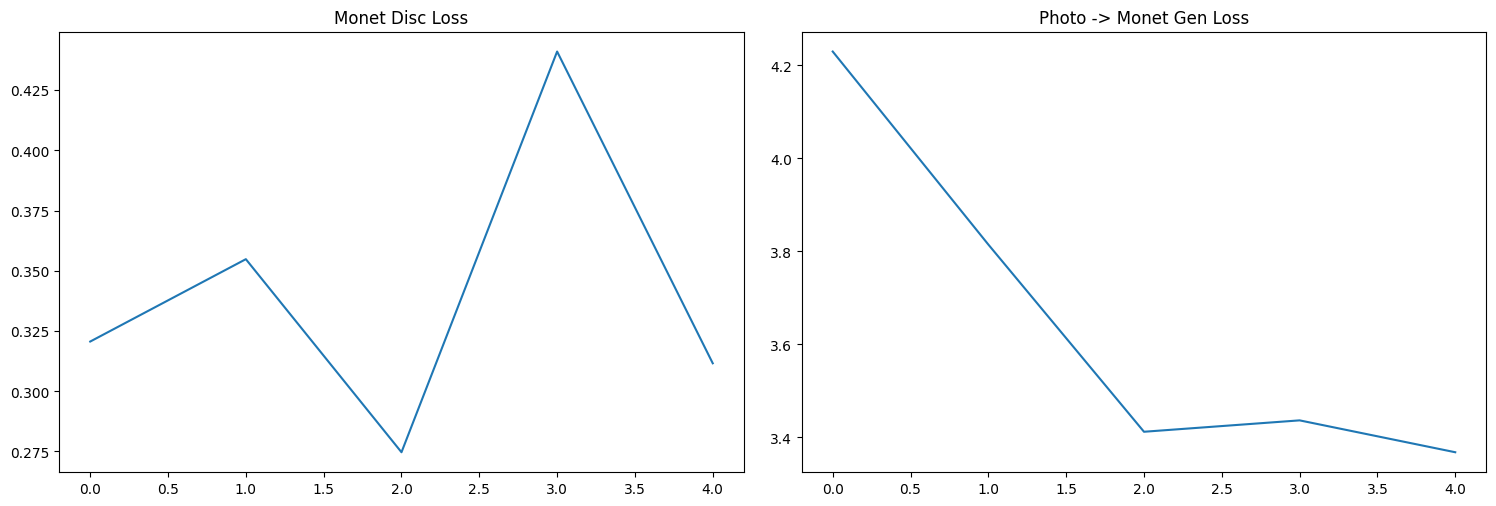

In [36]:
show_model_history(cycle_history)

In [40]:
df = pd.DataFrame.from_dict(model_results, orient='index')
df.columns = ['Model', 'Training Time', 'Epochs', 'Min Monet Discriminator Loss', 'Min Monet Generator Loss']
df = df.sort_values('Min Monet Generator Loss')
df.head()

,Model,Training Time,Epochs,Min Monet Discriminator Loss,Min Monet Generator Loss
0,CycleGAN - Lambda 10,368.001262,5,0.274690,3.367947
2,CycleGAN - Lambda 50,343.928071,5,0.102235,9.506583
1,CycleGAN - Lambda 100,344.028513,5,0.158804,21.346218


# Step 5:  Conclusion
As mentioned above, the lambda = 50 model was my best performing model in terms of discriminator loss.  All three models performed similarly in terms of training duration.


## Learnings and Takeaways
There appears to be both an art and a science to create machine learning models.  Choosing the right architecture and hyperparameters significantly impact the prediction power of the model.

There are multiple hyperparameter options to tune.  I opted to tune the lambda parameter to see the effect on the loss function, but I could have tuned the beta or learning rate parameters associated with the optimizers to see the impact on model convergence.

## What did and did not help improve the performance of your models? 
As mentioned above, the value of lambda had a direct impage on the generator loss of the model.  However, I wasn't sure what to expect regarding the discriminator loss.  I found that a moderate value of 50 produced the lowest discriminator loss.

My results matched my expectations in that the training time of my model remained relatively flat across the different lambda values.  This is because the lambda parameter is used in the calculation of the generator loss.  Other hyperparameters, such as learning rate, could influence how long it takes for the model to converge leading to different training durations.

## What improvements could you try in the future?
In the future, I could try a DCGAN architecture to create a Monet-style image from scratch rather than transforming an existing photo to Monet-style.  Additionally, I could tune different hyperparameters as mentioned above.

I could also try to add random noise (e.g., flipping, cropping) to the images prior to training the model.  This would help avoid any overfitting and improve generalization of the model.


# Submit to Competition
The remainder of this notebook (except for the references section) is the code needed to submit predictions to the Kaggle competition.

In [ ]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
i = 1
for img in photo_ds:
    prediction = photo_to_monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = PIL.Image.fromarray(prediction)
    image.save(OUTPUT_PATH + str(i) + '.jpg')
    i += 1

In [ ]:
import shutil
shutil.make_archive('images', 'zip', '/kaggle/working/images')

# References
1. https://www.kaggle.com/competitions/gan-getting-started
2. https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset
3. https://keras.io/examples/keras_recipes/tfrecord/
4. https://keras.io/examples/generative/dcgan_overriding_train_step/
5. https://www.tensorflow.org/tutorials/generative/dcgan
6. https://www.tensorflow.org/tutorials/generative/cyclegan
7. https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-2-73233a670d19
8. https://medium.com/data-science/gan-ways-to-improve-gan-performance-acf37f9f59b
9. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Build-the-discriminator
10. https://keras.io/guides/custom_train_step_in_tensorflow/